In [1]:
# params
IMAGE_SIZE = 227
NUM_CHANELLS = 3
LEN_FEATURES = IMAGE_SIZE * IMAGE_SIZE * NUM_CHANELLS
NUM_OF_EPOCHS = 30
NUM_OF_IMAGES = 9000
BATCH_SIZE = 64
CLASSES = ['happy', 'sad']

# paths
PATH = r"D:\\Projects\Development\\courses_projects\\deep_learning_and_natural_language_processing\\dog-image-mood-classification"
PATH_TO_DATA = PATH + '\\' + "data\\cleared_images"
MODEL_HISTORY_FILEPATH = PATH + '\\' + r"models_history\\model_2.hdf5"

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "8"

In [3]:
# modeling
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
import cv2

# tools
from typing import Tuple
import os
import random
import numpy as np
from datetime import datetime

# warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [4]:
def load_data(classes) -> Tuple[np.array, np.array]:
  images = []
  labels = []
  files = []
  for i in range(len(classes)):
    folder_name = classes[i]
    path = os.path.join(PATH_TO_DATA, folder_name)
    count = 0
    for file_name in os.listdir(path):
      file_name = os.path.join(path, file_name)
      image = cv2.imread(file_name)
      image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
      images.append(image)
      label = [i]
      labels.append(label)
      files.append(os.path.join(path, file_name))
      if count == NUM_OF_IMAGES / 2:
        break
      count += 1
  return np.array(images), np.array(labels)

def plot_images(images, cls_true, cls_pred=None):
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
    if cls_pred is not None:
        images, cls_true, cls_pred  = zip(*[(images[i], cls_true[i], cls_pred[i]) for i in random_indices])
    else:
        images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
        xlabel = f"True: {cls_true[i]}" if cls_pred is None else f"True: {cls_true[i]}, Pred: {cls_pred[i]}"
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

def make_vactors(labels) -> np.array:
  new_labels = []
  for label in labels:
      value = label[0]
      new_label = [0] * len(CLASSES)
      new_label[value] = 1
      new_labels.append(new_label)
  return np.array(new_labels)

In [5]:
train_images, train_labels = load_data(CLASSES)
train_images, train_labels = shuffle(train_images, train_labels)

In [6]:
print(f"Shape of training data: {train_images.shape}")

Shape of training data: (9002, 227, 227, 3)


In [7]:
print(f"Size of train: {len(train_images)}")

Size of train: 9002


In [8]:
x_train = train_images.astype('float32') / 255.0
y_train = np.asarray(train_labels).astype('float32').reshape((-1,1))

In [9]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 227, 227, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 113, 113, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 55, 55, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 55, 55, 64)        1

In [11]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=MODEL_HISTORY_FILEPATH,
    monitor='val_accuracy',
    mode='auto',
    save_best_only=True
    )

train_scores = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_OF_EPOCHS, shuffle=True, validation_split=0.2, callbacks=[model_checkpoint_callback])

Epoch 1/30
113/113 [==============================] - 456s 4s/step - loss: 0.6940 - accuracy: 0.4970 - val_loss: 0.6940 - val_accuracy: 0.4853
Epoch 2/30
113/113 [==============================] - 449s 4s/step - loss: 0.6932 - accuracy: 0.5037 - val_loss: 0.6934 - val_accuracy: 0.4853
Epoch 3/30
113/113 [==============================] - 447s 4s/step - loss: 0.6932 - accuracy: 0.4948 - val_loss: 0.6932 - val_accuracy: 0.4853
Epoch 4/30
113/113 [==============================] - 446s 4s/step - loss: 0.6932 - accuracy: 0.5037 - val_loss: 0.6933 - val_accuracy: 0.4853
Epoch 5/30
113/113 [==============================] - 447s 4s/step - loss: 0.6932 - accuracy: 0.5037 - val_loss: 0.6934 - val_accuracy: 0.4853
Epoch 6/30
113/113 [==============================] - 446s 4s/step - loss: 0.6931 - accuracy: 0.5037 - val_loss: 0.6933 - val_accuracy: 0.4853
Epoch 7/30
113/113 [==============================] - 447s 4s/step - loss: 0.6931 - accuracy: 0.5037 - val_loss: 0.6933 - val_accuracy: 0.4853

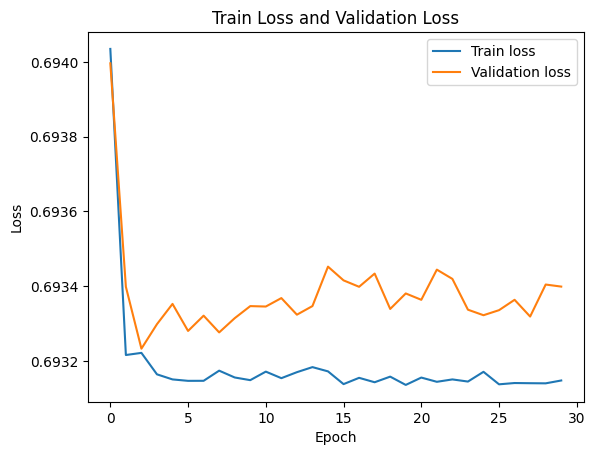

In [12]:
plt.title("Train Loss and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(np.arange(NUM_OF_EPOCHS), train_scores.history['loss'])
plt.plot(np.arange(NUM_OF_EPOCHS), train_scores.history['val_loss'])
plt.legend(["Train loss", "Validation loss"])
plt.show()

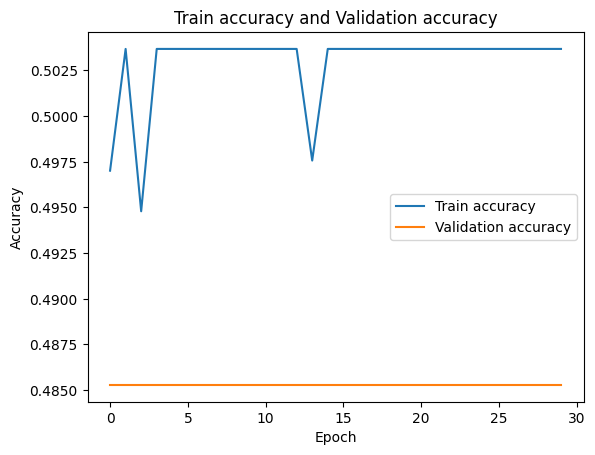

In [13]:
plt.title("Train accuracy and Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(np.arange(NUM_OF_EPOCHS), train_scores.history['accuracy'])
plt.plot(np.arange(NUM_OF_EPOCHS), train_scores.history['val_accuracy'])
plt.legend(["Train accuracy", "Validation accuracy"])
plt.show()